<h2>EDA on Online Sales Data</h2>
<ul>
    <li><a href="href="https://www.kaggle.com/datasets/arnavsmayan/online-retail-sales-dataset>Online Retail Sales Dataset</a></li>
    <li>This dataset will provide synthetic data for online retail sales, which include details of customer transactions and orders with regard to the involved items, their quantities, prices, discounts, methods of payment, and the customers' demographics for analysis in terms of buying behavior, sales trend, inventory management, and marketing strategy. </li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
from scipy.stats import shapiro, normaltest, zscore

In [2]:
# Set visual display settings
sns.set(style='whitegrid')

<h3>Load CSV</h3>

In [3]:
original_df = pd.read_csv('online_retail_sales_dataset.csv')

In [4]:
original_df.head()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount
0,1,2023-01-01 00:00:00,1993,915,Home & Kitchen,8,103.30,0.23,Gift Card,27,Female,North America,636.33
1,2,2023-01-01 00:01:00,3474,553,Clothing,9,180.28,0.31,Gift Card,53,Other,South America,1119.54
2,3,2023-01-01 00:02:00,4564,248,Beauty & Personal Care,7,81.58,0.27,Debit Card,34,Other,North America,416.87
3,4,2023-01-01 00:03:00,1133,948,Clothing,3,235.20,0.00,Debit Card,50,Other,Australia,705.60
4,5,2023-01-01 00:04:00,3626,284,Books,9,453.00,0.34,Credit Card,23,Female,Australia,2690.82


<h3>DF Overview</h3>

In [5]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   transaction_id     1000000 non-null  int64  
 1   timestamp          1000000 non-null  object 
 2   customer_id        1000000 non-null  int64  
 3   product_id         1000000 non-null  int64  
 4   product_category   1000000 non-null  object 
 5   quantity           1000000 non-null  int64  
 6   price              1000000 non-null  float64
 7   discount           1000000 non-null  float64
 8   payment_method     1000000 non-null  object 
 9   customer_age       1000000 non-null  int64  
 10  customer_gender    1000000 non-null  object 
 11  customer_location  1000000 non-null  object 
 12  total_amount       1000000 non-null  float64
dtypes: float64(3), int64(5), object(5)
memory usage: 99.2+ MB


In [6]:
original_df.shape
# (rows, columns)

(1000000, 13)

In [7]:
# Descriptive stat of selected numeric columns
original_df[['quantity', 'price', 'discount', 'customer_age', 'total_amount']].describe()

,quantity,price,discount,customer_age,total_amount
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,5.003086,252.445705,0.250204,43.508625,946.839858
std,2.581004,142.868633,0.144384,15.007346,810.902205
min,1.000000,5.000000,0.000000,18.000000,2.560000
25%,3.000000,128.690000,0.130000,31.000000,297.180000
50%,5.000000,252.700000,0.250000,44.000000,715.710000
75%,7.000000,375.990000,0.380000,57.000000,1397.750000
max,9.000000,500.000000,0.500000,69.000000,4496.130000


<h3>Data Cleaning</h3>

<h4>Handling Missisng Values</h4>

In [8]:
# identify columns with missing values
original_df.isnull().sum()
# DF has no NAN

transaction_id       0
timestamp            0
customer_id          0
product_id           0
product_category     0
quantity             0
price                0
discount             0
payment_method       0
customer_age         0
customer_gender      0
customer_location    0
total_amount         0
dtype: int64

<strong>Suggestions if missing values are present<strong>
<p>
For numeric column
`df['col'] = df['col'].fillna(0)`

Option to fill missing values in a specific column with the mean
```df['price'].fillna(df['price'].mean(), inplace=True)```

For non-numer cols replace with appropriate string
```df['col'] = df['col'].fillna('blah!')```
</p>
<p>
<strong>Rationale</strong>: Handling missing values ensures comprehensive datasets, reducing biases during analysis. This practice allows for better data integrity and improved predictive performance. 
</p>

<h4>Handling Duplicate Rows</h4>

In [9]:
# check for duplicate rows
original_df.duplicated().sum()
# DF has no duplicate rows

np.int64(0)

In [10]:
# suggestions if there are duplicate rows
# remove duplicate rows
original_df = original_df.drop_duplicates()
# Rationale: By eliminating duplicates, data clarity is enhanced, allowing for more accurate insights from analyses.

In [11]:
original_df.shape

(1000000, 13)

<h4>Correcting Data Type for df['timestamp']</h4>
<p>
<a href="https://en.wikipedia.org/wiki/Date_and_time_notation_in_the_Philippines#:~:text=Date%20and%20time%20notation%20in%20the%20Philippines%20varies%20across%20the%20country%20in%20various%2C%20customary%20formats.%20Some%20government%20agencies%20in%20the%20Philippines%20have%20adopted,Multi%2DPurpose%20ID.
">In the Philippines, the recommended timestamp format conforms to the ISO 8601 standard</a>, which prescribes the format as YYYY-MM-DD for dates and utilizes the 24-hour clock format for times, resulting in a complete representation such as 2023-01-01T00:02:00. This standardization enhances clarity and mitigates ambiguity in datetime notation, making it appropriate for legal and technical applications.
</p>
<p>Our group formatted the timestamp column to ISO 8601 utilizes the 24-hour clock format for times and create df['date'] for timestamp without 24-hour clock format.
</p>

In [12]:
# ISO 8601 utilizes the 24-hour clock format for times
original_df['timestamp'] = pd.to_datetime(original_df['timestamp']).apply(lambda x: x.isoformat())
# ISO 8601 with date  only
original_df['date'] = pd.to_datetime(original_df['timestamp']).dt.date

<p><b>Rationale</b>: Correct data types minimize the risk of errors during computations and support the correct functioning of analysis functions.</p>

In [13]:
original_df.tail()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount,date
999995,999996,2024-11-25T10:35:00,1324,833,Clothing,9,318.66,0.30,PayPal,58,Other,Asia,2007.56,2024-11-25
999996,999997,2024-11-25T10:36:00,3671,260,Books,7,283.78,0.30,Credit Card,32,Male,North America,1390.52,2024-11-25
999997,999998,2024-11-25T10:37:00,3651,293,Electronics,8,418.59,0.42,Gift Card,19,Male,Australia,1942.26,2024-11-25
999998,999999,2024-11-25T10:38:00,3253,534,Home & Kitchen,6,258.94,0.13,Credit Card,38,Other,North America,1351.67,2024-11-25
999999,1000000,2024-11-25T10:39:00,3337,826,Electronics,9,76.06,0.47,Gift Card,59,Male,North America,362.81,2024-11-25


<h4>Data Type Consistency</h4>
<p>Ensure that each column has the correct data type for consistency</p>

In [14]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   transaction_id     1000000 non-null  int64  
 1   timestamp          1000000 non-null  object 
 2   customer_id        1000000 non-null  int64  
 3   product_id         1000000 non-null  int64  
 4   product_category   1000000 non-null  object 
 5   quantity           1000000 non-null  int64  
 6   price              1000000 non-null  float64
 7   discount           1000000 non-null  float64
 8   payment_method     1000000 non-null  object 
 9   customer_age       1000000 non-null  int64  
 10  customer_gender    1000000 non-null  object 
 11  customer_location  1000000 non-null  object 
 12  total_amount       1000000 non-null  float64
 13  date               1000000 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 106.8+ MB


In [15]:
original_df['customer_id'] = original_df['customer_id'].astype(int)  # Ensure customer_id is integer type
original_df['quantity'] = original_df['quantity'].astype(int)  # Ensure quantity is integer type
original_df['price'] = original_df['price'].astype(float)  # Ensure price is float type
original_df['date'] = original_df['date'].astype(str)  # Ensure date is str type

In [16]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   transaction_id     1000000 non-null  int64  
 1   timestamp          1000000 non-null  object 
 2   customer_id        1000000 non-null  int64  
 3   product_id         1000000 non-null  int64  
 4   product_category   1000000 non-null  object 
 5   quantity           1000000 non-null  int64  
 6   price              1000000 non-null  float64
 7   discount           1000000 non-null  float64
 8   payment_method     1000000 non-null  object 
 9   customer_age       1000000 non-null  int64  
 10  customer_gender    1000000 non-null  object 
 11  customer_location  1000000 non-null  object 
 12  total_amount       1000000 non-null  float64
 13  date               1000000 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 106.8+ MB


<p>Rationale: Inconsistent data entries can lead to misleading analysis results, and ensuring uniformity is crucial for accurate data processing.</p>

<h4>Standardizing Categorical Variables</h4>

In [17]:
# Lowercase payment methods
original_df['payment_method'] = original_df['payment_method'].str.lower()

# One-hot encoding for categorical variables
original_df = pd.get_dummies(original_df, columns=['customer_gender']) 

# original_df = pd.get_dummies(original_df, columns=['product_category', 'customer_gender', 'customer_location'], drop_first=True)  # One-hot encoding for categorical variables
#

In [18]:
original_df.columns

Index(['transaction_id', 'timestamp', 'customer_id', 'product_id',
       'product_category', 'quantity', 'price', 'discount', 'payment_method',
       'customer_age', 'customer_location', 'total_amount', 'date',
       'customer_gender_Female', 'customer_gender_Male',
       'customer_gender_Other'],
      dtype='object')

In [19]:
original_df.shape

(1000000, 16)

In [20]:
# original_df.tail()

<p>Rationale: Convert categorical variables into a consistent format, which may involve lowercasing or encoding.</p>

<h4>Outlier Detection and Management</h4>

<p>Definition of Quartiles:</p>
<ul>
    <li>Q1 (First Quartile): This is the 25th percentile of the data, meaning that 25% of the data points are below this value.</li>
    <li>Q3 (Third Quartile): This is the 75th percentile, indicating that 75% of the data points are below this value.</li>
</ul>
<p>Calculating IQR:</p>
<ul>
    <li>The Interquartile Range (IQR) is calculated as: $$IQR=Q3−Q1$$</li>
    <li>The IQR represents the range within which the central 50% of the data points lie.</li>
</ul>
<p>Identifying Outliers:</p>
<ul>
    <li>Outliers are defined as any data points that fall below Q1−1.5×IQR or above Q3+1.5×IQR.</li>
    <li>Once outliers are identified, they can be removed from the dataset to ensure that subsequent analyses are not skewed by these extreme values.</li>
</ul>

In [21]:
# z_scores = np.abs(zscore(original_df[['quantity', 'price', 'total_amount']]))

# Keep rows where z-score is less than 3
# original_df = original_df[(z_scores < 3).all(axis=1)]  

In [22]:
original_df.shape

(1000000, 16)

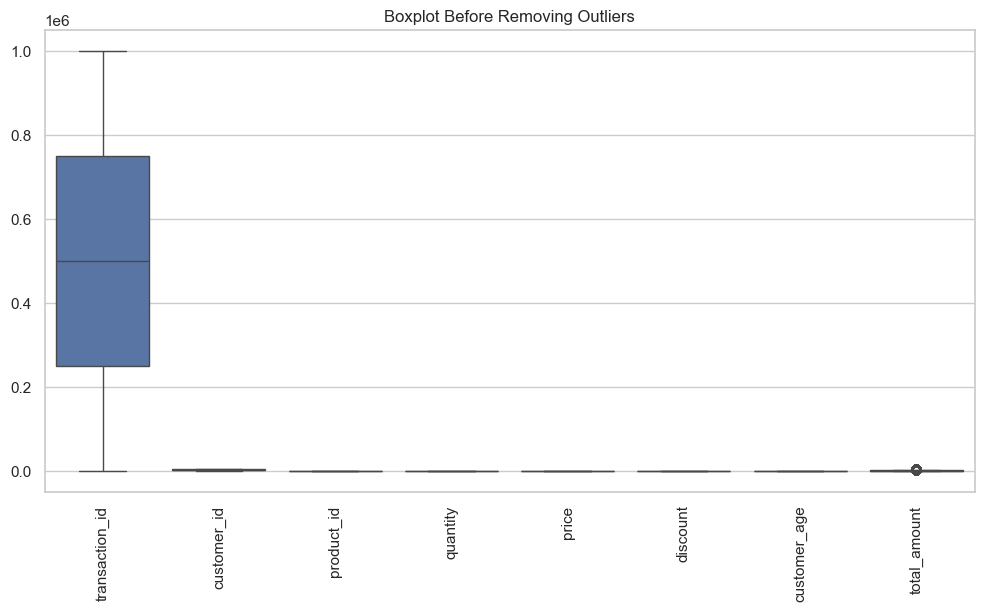

In [23]:
# Boxplot before cleaning
numeric_columns = original_df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12,6))
sns.boxplot(data=original_df[numeric_columns])
plt.title("Boxplot Before Removing Outliers")
plt.xticks(rotation=90)
plt.show()

In [24]:
def remove_outliers_iqr(df):
    df_filtered = df.copy()

    # For each numeric column, Q1 and Q3 are calculated using quantile(), and then IQR is computed.
    
    for column in numeric_columns:
        Q1 = df_filtered[column].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df_filtered[column].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        
        # Define bounds for outliers
        # The lower and upper bounds for identifying outliers are established.
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        # Rows containing outliers are removed based on these bounds
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]

    # Cleaned DataFrame without outliers is returned
    return df_filtered

In [25]:
cleaned_df = remove_outliers_iqr(original_df)

In [26]:
print("Original dataset shape:", original_df.shape)
print("Cleaned dataset shape:", cleaned_df.shape)

Original dataset shape: (1000000, 16)
Cleaned dataset shape: (978015, 16)


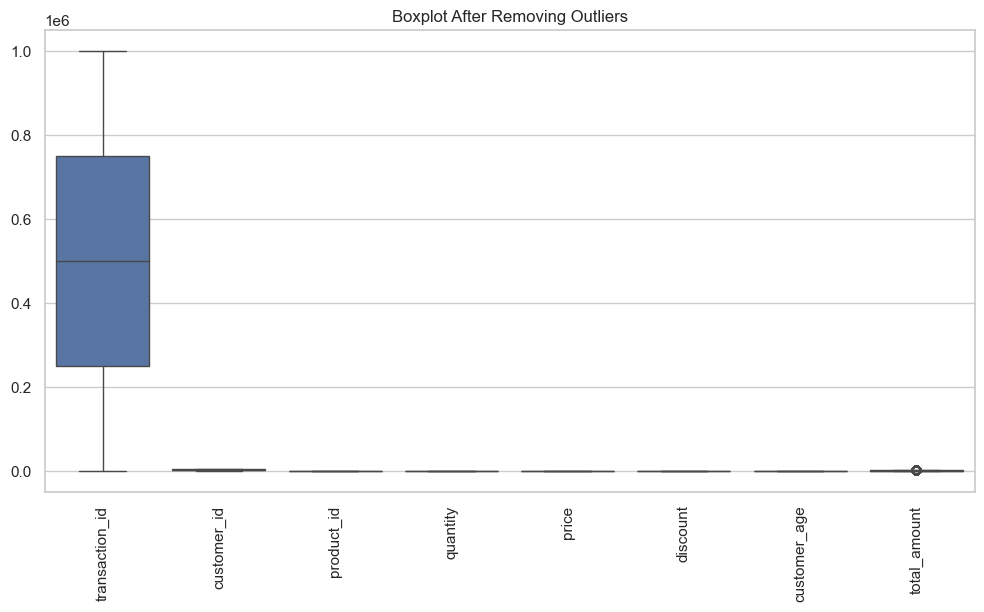

In [27]:
# Boxplot after cleaning
plt.figure(figsize=(12,6))
sns.boxplot(data=cleaned_df[numeric_columns])
plt.title("Boxplot After Removing Outliers")
plt.xticks(rotation=90)
plt.show()

<p><b>Rationale</b>: Outlier management assures the robustness of analyses, as they can detrimentally affect interpretations and model accuracy. Ensure that the dataset has enough data points after removing outliers; if too many rows are removed, consider adjusting the IQR multiplier or using alternative methods like Z-score or robust statistical techniques.</p>

<h4>Data Preprocessing</h4>
<p>
   <a href="https://www.statology.org/z-score-python/"><b>Standardization</b></a>, also known as Z-score normalization, involves rescaling the data such that it has a mean (μ) of 0 and a standard deviation (σ) of 1. 
</p>
<p>This transformation allows the data to be centered around zero, which is particularly useful for algorithms that assume normal distribution or rely on distance metrics. Standardization, is beneficial in scenarios where the dataset contains features with different units or scales.</p>
<p><a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781788393485/fd5b8a44-e9d3-4c19-bebb-c2fa5a5ebfee.xhtml"><b>Normalization</b></a>, often referred to as Min-Max scaling, rescales the features to a specific range, typically [0, 1]. In this method, the minimum and maximum values in the dataset are used to ensure that all features contribute equally to the computation.</p>

<p>One key difference between these two techniques is their sensitivity to outliers. Standardization is less affected by outliers since it centers the data based on the mean and standard deviation. Normalization, however, can be significantly influenced by extreme values, as it directly uses the minimum and maximum values of the dataset, which can result in skewed scales.</p>


In [28]:
# rescales the data to a fixed range, typically [0, 1]. 
# to maintain data integrity and prevent anomalies during data operations
# identify numerical columns              
numeric_cols_cleaned = cleaned_df.select_dtypes(include=[np.number]).columns.tolist()

# identify categorical columns
categorical_cols = cleaned_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Normalizing numerical columns
scaler = StandardScaler()
cleaned_df[numeric_cols_cleaned] = scaler.fit_transform(cleaned_df[numeric_cols_cleaned])

# Display the normalized DataFrame
cleaned_df.head()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_location,total_amount,date,customer_gender_Female,customer_gender_Male,customer_gender_Other
0,-1.732240,2023-01-01T00:00:00,-0.871179,1.405299,Home & Kitchen,1.204753,-1.024704,-0.164310,gift card,-1.100096,North America,-0.350402,2023-01-01,True,False,False
1,-1.732236,2023-01-01T00:01:00,0.411474,0.012304,Clothing,1.596432,-0.479542,0.392184,gift card,0.632203,South America,0.314887,2023-01-01,False,False,True
2,-1.732233,2023-01-01T00:02:00,1.355493,-1.161353,Beauty & Personal Care,0.813073,-1.178522,0.113937,debit card,-0.633708,North America,-0.652557,2023-01-01,False,False,True
3,-1.732229,2023-01-01T00:03:00,-1.616001,1.532285,Clothing,-0.753645,-0.090607,-1.764229,debit card,0.432322,Australia,-0.255030,2023-01-01,False,False,True
4,-1.732226,2023-01-01T00:04:00,0.543117,-1.022823,Books,1.596432,1.451822,0.600869,credit card,-1.366604,Australia,2.478243,2023-01-01,True,False,False


<p><b>Rationale</b>: <a href="https://builtin.com/data-science/when-and-why-standardize-your-data">Standardizing</a> or normalizing data is crucial for maintaining data quality, ensuring consistency, and facilitating effective analysis across datasets. These processes help to eliminate redundancies, reduce errors, and enhance the overall usability of data. Understanding the rationale behind these practices is essential for effective data management and decision-making.</p>

<h4>Sampling</h4>
<b>Standard Sample Size Considerations</b>
<ul>
    <li>A sample of <a href="https://www.qualtrics.com/experience-management/research/determine-sample-size/#:~:text=A%20good%20sample%20size%20really%20depends%20on%20the%20context%20and%20goals%20of%20the%20research.%20In%20general%2C%20a%20good,statistical%20analysis.">358 is sometimes considered standard</a> due to statistical guidelines that help balance accuracy and practicality.</li>
    <li><a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2993974/#:~:text=A%20very%20large%20sample%20size%20is%20also%20not%20recommended%20as%20it%20has%20its%20own%20consequences.%20First%2C,time%20and">This number can provide a reasonable assurance of representing the population well while allowing for sufficient power in statistical tests.</a></li>
    <li><a href="https://academic.oup.com/ejcts/article/54/1/4/4994996?login=false#">Depending on the specific research goals, using a sample size like 358 can yield very reliable data while still being manageable in scale.</a></li>
    <li>Therefore, our group will choose an n=1000 for given N=1000000.</li>
</ul>

In [29]:
df = cleaned_df.sample(n=1000, random_state=42)  # random_state is optional for reproducibility

In [30]:
print("Shape before sampling:", cleaned_df.shape)
print("Shape after sampling:", df.shape)

Shape before sampling: (978015, 16)
Shape after sampling: (1000, 16)


In [31]:
df.head()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_location,total_amount,date,customer_gender_Female,customer_gender_Male,customer_gender_Other
733611,0.809260,2024-05-24T10:51:00,-1.204616,-0.091594,Home & Kitchen,-1.145325,-0.284012,1.574733,credit card,-1.299977,North America,-0.928827,2024-05-24,False,True,False
173507,-1.131147,2023-05-01T11:47:00,-1.295554,0.881964,Electronics,-0.753645,-0.505603,1.435610,debit card,-0.500454,Australia,-0.832616,2023-05-01,False,False,True
57897,-1.531663,2023-02-10T04:57:00,-1.571831,-0.530272,Books,-1.145325,1.371089,-1.764229,credit card,0.698830,North America,-0.010508,2023-02-10,False,True,False
50093,-1.558699,2023-02-04T18:53:00,-1.461840,-0.657258,Beauty & Personal Care,-0.361966,-1.079730,-0.025186,gift card,-1.233350,Europe,-0.831927,2023-02-04,False,False,True
410505,-0.310099,2023-10-13T01:45:00,-1.555376,-1.038215,Beauty & Personal Care,1.204753,-0.125237,-0.372995,credit card,0.165815,Asia,0.802884,2023-10-13,True,False,False


<h4>Data Distribution</h4>

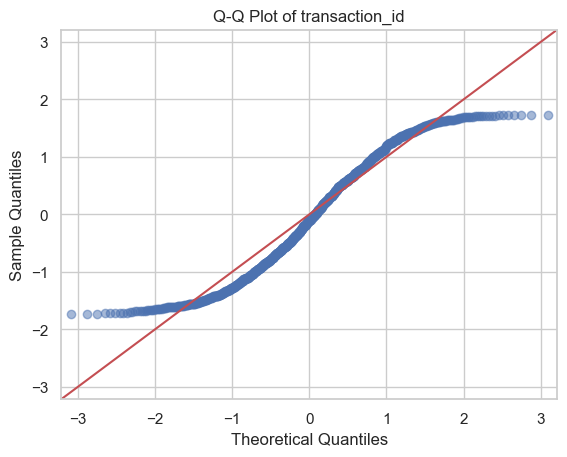

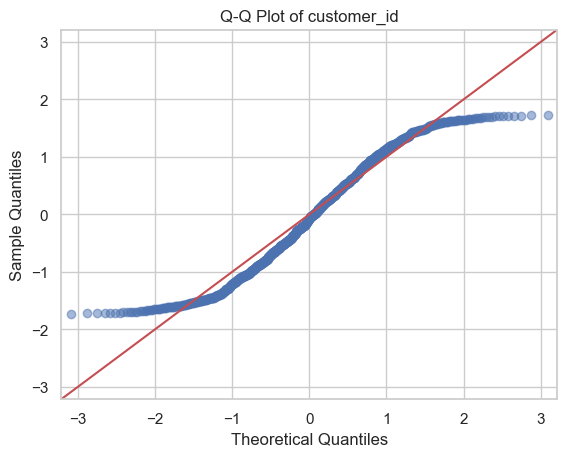

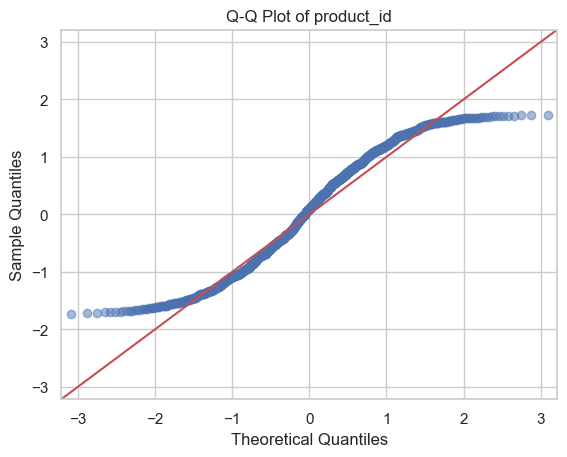

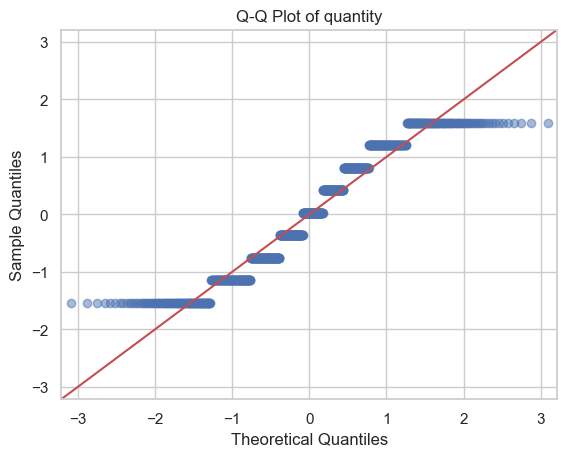

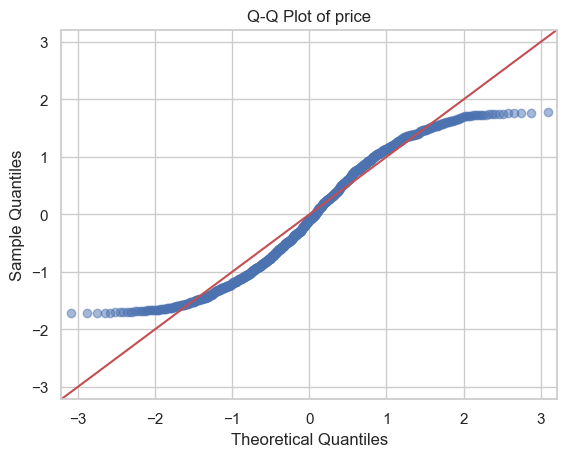

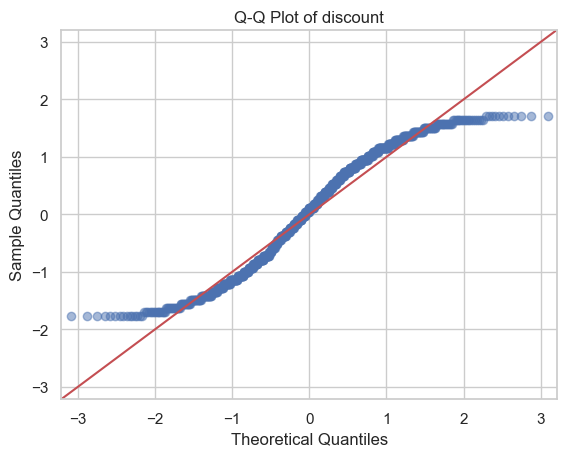

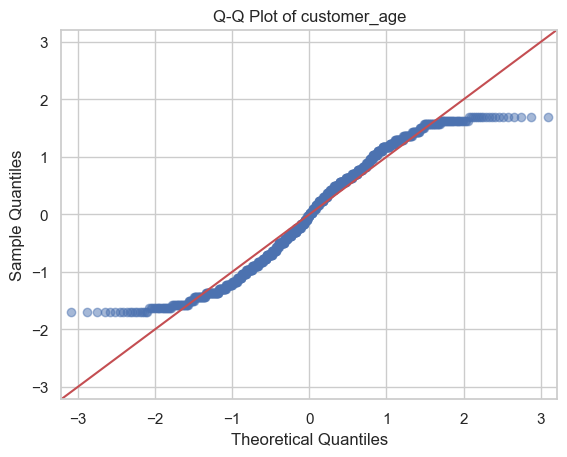

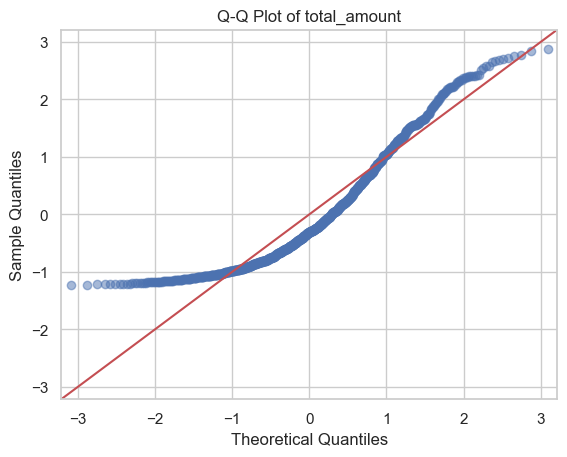

In [32]:
# Q-Q Plot
num_cols = df.select_dtypes(include=[np.number])

for col in num_cols.columns:
    sm.qqplot(df[col], line='45', alpha=0.5)
    plt.title(f'Q-Q Plot of {col}')
    plt.show()



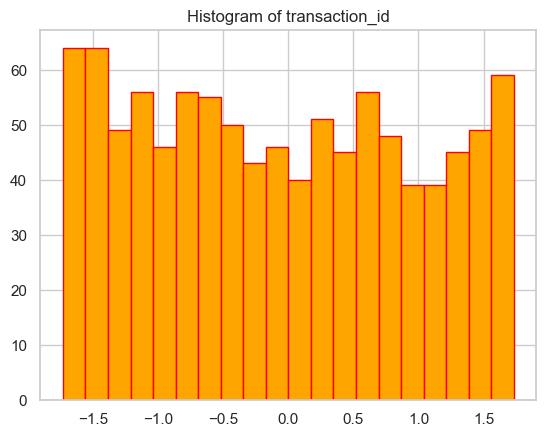

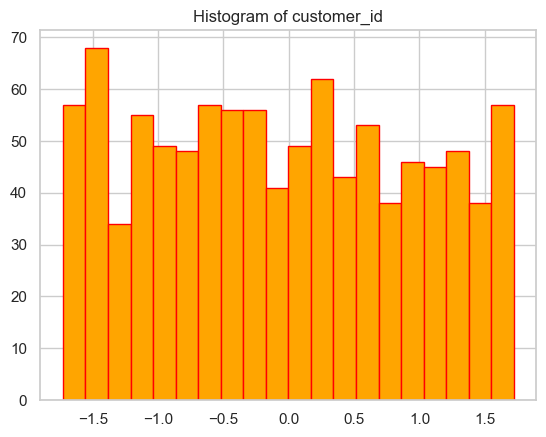

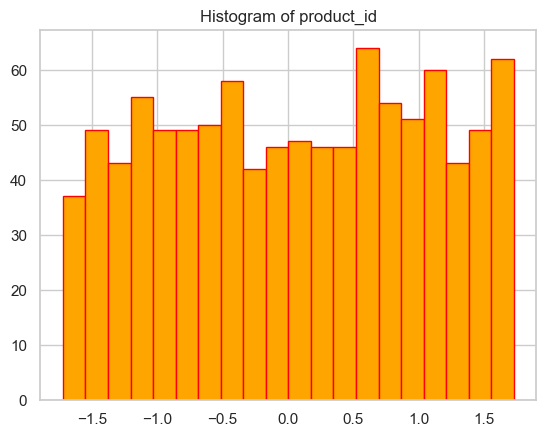

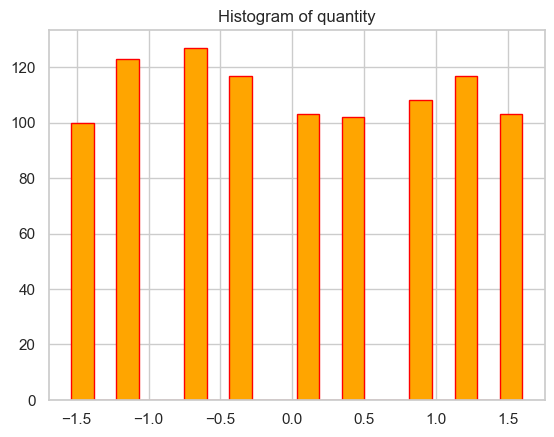

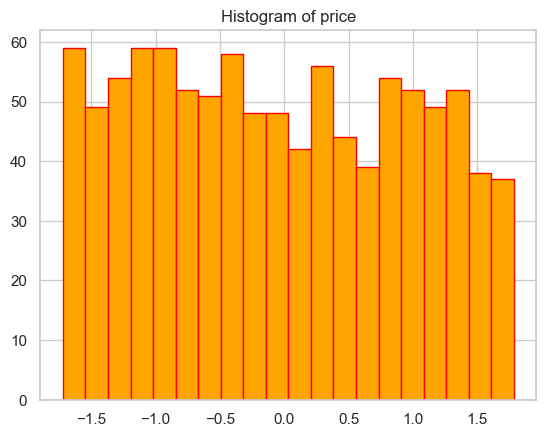

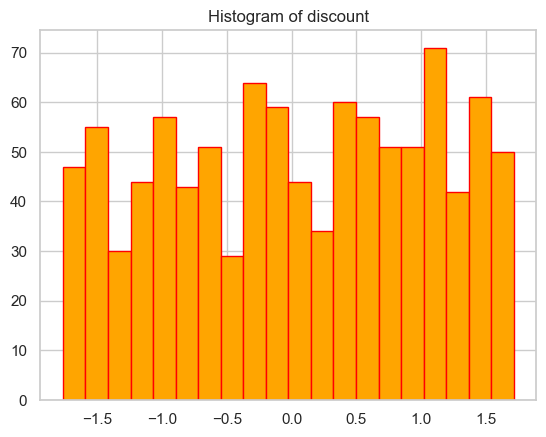

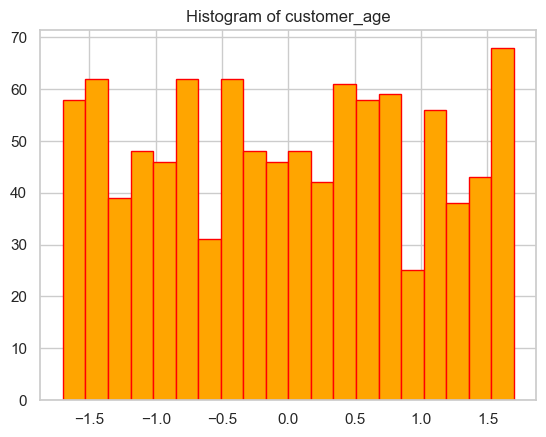

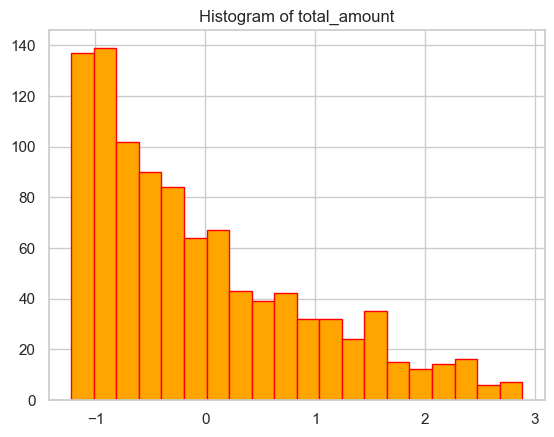

In [33]:
# Histogram
for col in num_cols.columns:
    plt.figure()
    plt.hist(num_cols[col], bins=20, color='orange', edgecolor='red')
    plt.title(f'Histogram of {col}')
    plt.show()

<h4>Test for Normality</h4>
<p><p>If the p-value is below significance level (e.g., 0.05), 
reject the H0 and conclude that the data follows non-gaussian distribution.
</p></p>

In [34]:
# Perform Shapiro-Wilk test
shapiro_results = {}
for col in num_cols:
    stat, p = shapiro(df[col])
    shapiro_results[col] = (stat, p)

# Perform D'Agostino's K-squared test
dagostino_results = {}
for col in num_cols:
    stat, p = normaltest(df[col])
    dagostino_results[col] = (stat, p)

# Print results
print("Shapiro-Wilk Test Results:")
for col, result in shapiro_results.items():
    print(f"{col}: stat={result[0]:.4f}, p-value={result[1]:.4f}")

print("\nD'Agostino's K-squared Test Results:")
for col, result in dagostino_results.items():
    print(f"{col}: stat={result[0]:.4f}, p-value={result[1]:.4f}")
    
# if the p-value is below significance level (e.g., 0.05), 
# reject the H0 and conclude that the data is not normally distributed.

Shapiro-Wilk Test Results:
transaction_id: stat=0.9487, p-value=0.0000
customer_id: stat=0.9560, p-value=0.0000
product_id: stat=0.9547, p-value=0.0000
quantity: stat=0.9304, p-value=0.0000
price: stat=0.9539, p-value=0.0000
discount: stat=0.9531, p-value=0.0000
customer_age: stat=0.9548, p-value=0.0000
total_amount: stat=0.9009, p-value=0.0000

D'Agostino's K-squared Test Results:
transaction_id: stat=892.1941, p-value=0.0000
customer_id: stat=540.9796, p-value=0.0000
product_id: stat=742.1541, p-value=0.0000
quantity: stat=1125.9060, p-value=0.0000
price: stat=756.2837, p-value=0.0000
discount: stat=754.7376, p-value=0.0000
customer_age: stat=662.5705, p-value=0.0000
total_amount: stat=110.2561, p-value=0.0000
